In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the marketing data from CSV file
marketing_data = pd.read_csv('digital_marketing_campaign_dataset.csv')

# Drop AdvertisingPlatform, AdvertisingTool and CustomerID columns from the dataset
# These columns are removed as they are not relevant to the model.
marketing_data = marketing_data.drop(['AdvertisingPlatform', 'AdvertisingTool', 'CustomerID'], axis=1)

# Display the first few rows of the dataset to get an overview
marketing_data.head()



,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


In [15]:
# Display the info of the dataset to determine object types and non-null counts
marketing_data.info()

# Display summary statistics for the dataset
marketing_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                8000 non-null   int64  
 1   Gender             8000 non-null   object 
 2   Income             8000 non-null   int64  
 3   CampaignChannel    8000 non-null   object 
 4   CampaignType       8000 non-null   object 
 5   AdSpend            8000 non-null   float64
 6   ClickThroughRate   8000 non-null   float64
 7   ConversionRate     8000 non-null   float64
 8   WebsiteVisits      8000 non-null   int64  
 9   PagesPerVisit      8000 non-null   float64
 10  TimeOnSite         8000 non-null   float64
 11  SocialShares       8000 non-null   int64  
 12  EmailOpens         8000 non-null   int64  
 13  EmailClicks        8000 non-null   int64  
 14  PreviousPurchases  8000 non-null   int64  
 15  LoyaltyPoints      8000 non-null   int64  
 16  Conversion         8000 

,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,43.625500,84664.196750,5000.944830,0.154829,0.104389,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,0.876500
std,14.902785,37580.387945,2838.038153,0.084007,0.054878,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,0.329031
min,18.000000,20014.000000,100.054813,0.010005,0.010018,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,51744.500000,2523.221165,0.082635,0.056410,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,1.000000
50%,43.000000,84926.500000,5013.440044,0.154505,0.104046,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,1.000000
75%,56.000000,116815.750000,7407.989369,0.228207,0.152077,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,1.000000
max,69.000000,149986.000000,9997.914781,0.299968,0.199995,49.000000,9.999055,14.995311,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000


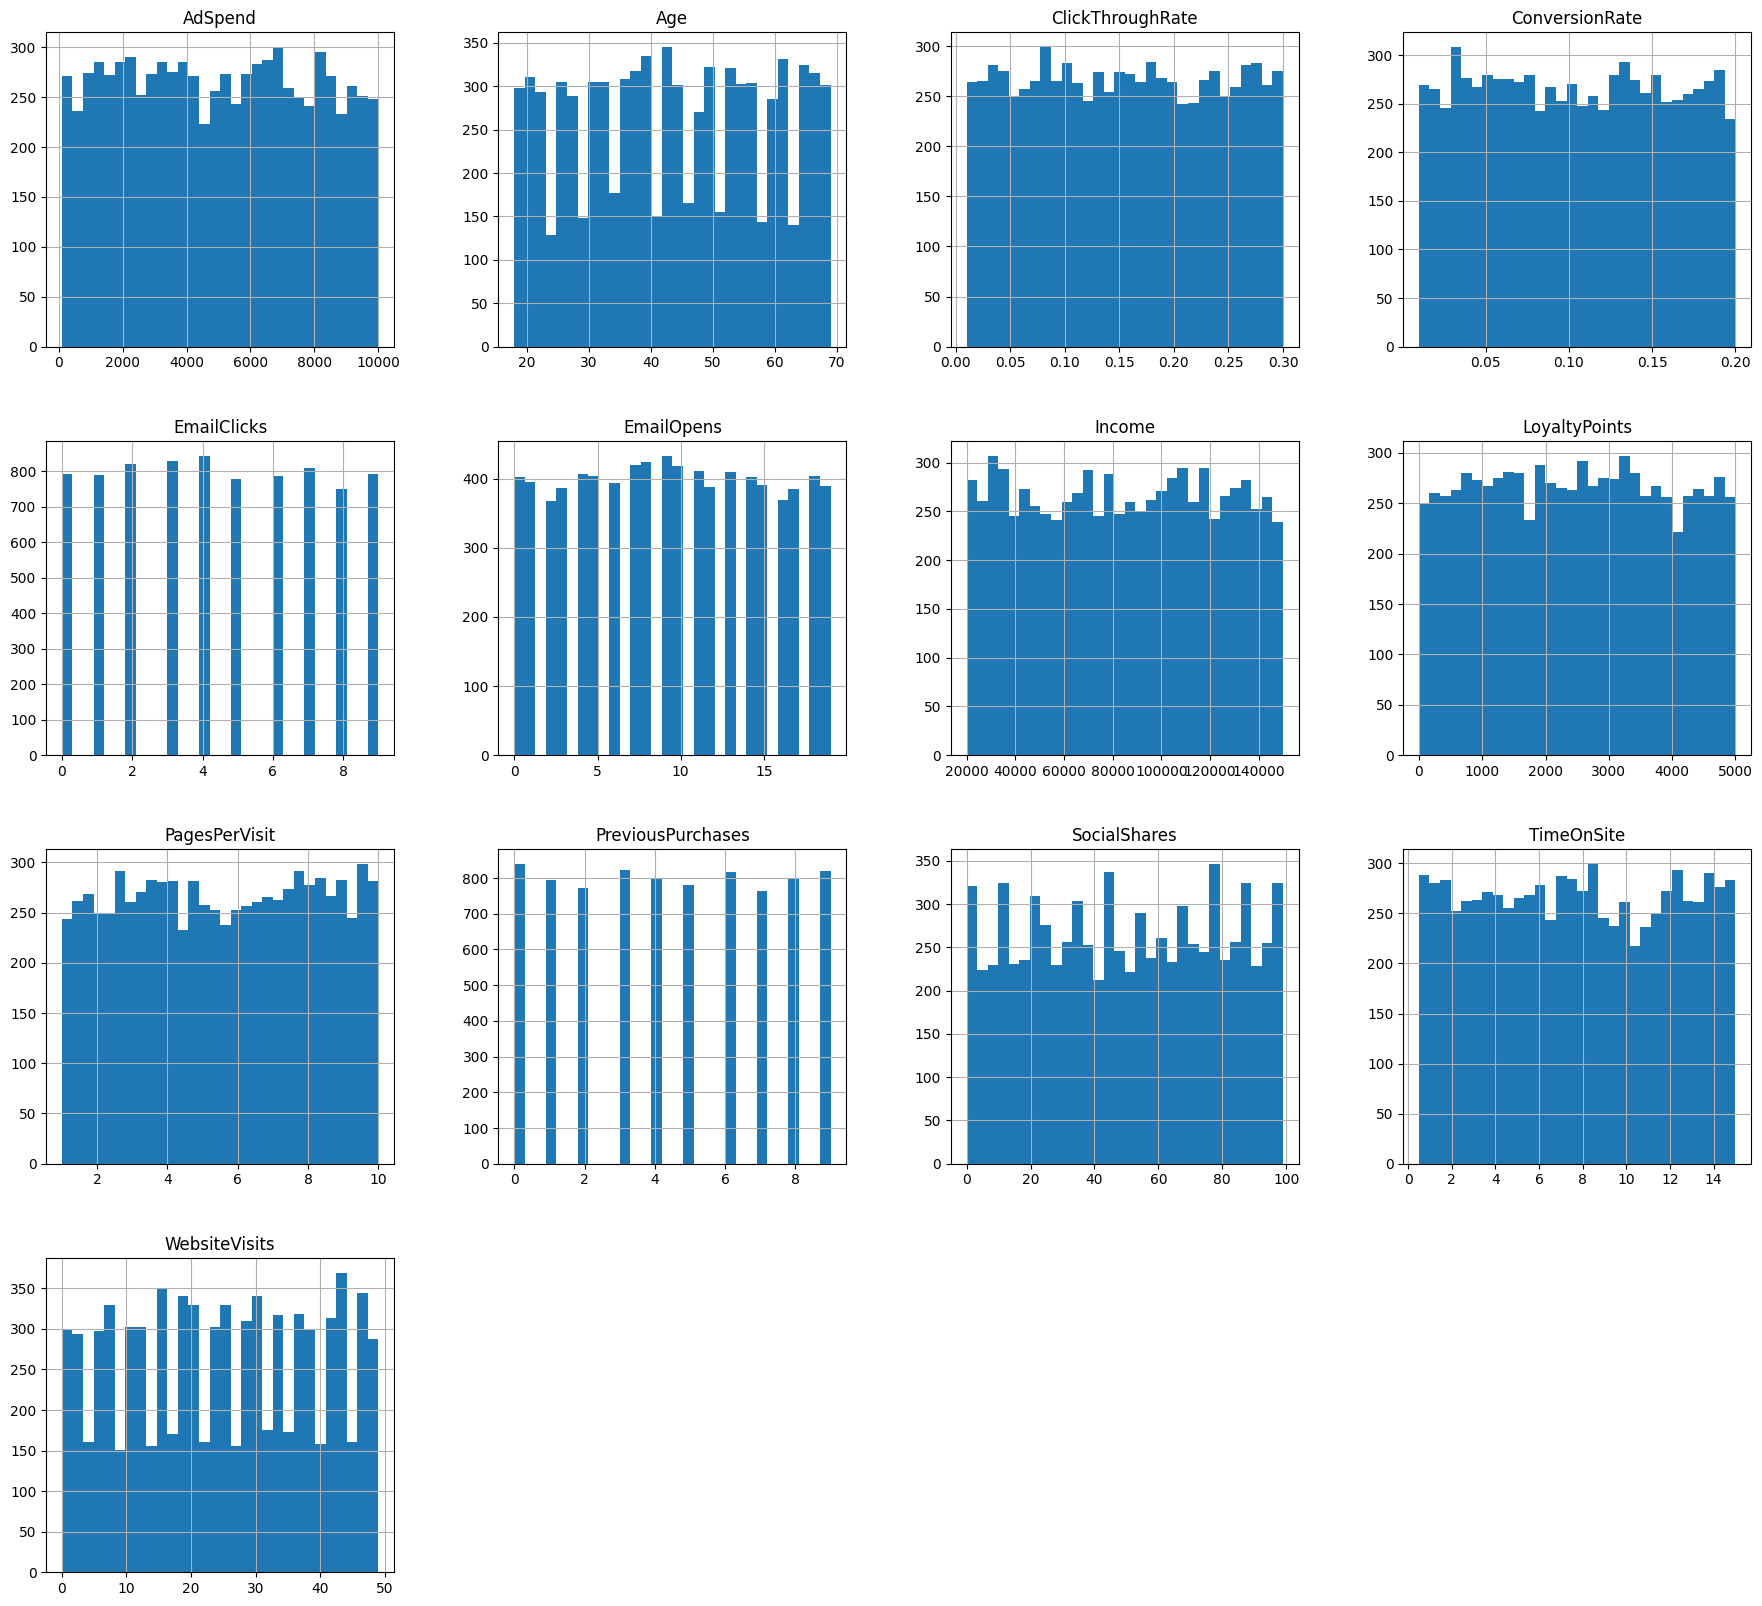

In [16]:
# Exclude the 'Conversion' column
columns_to_plot = marketing_data.columns.difference(['Conversion'])
subset_data = marketing_data[columns_to_plot]

# Plot histograms for numerical variables with increased spacing and rotated x-axis labels for better readability
subset_data.hist(bins=30, figsize=(22, 20))
plt.show()

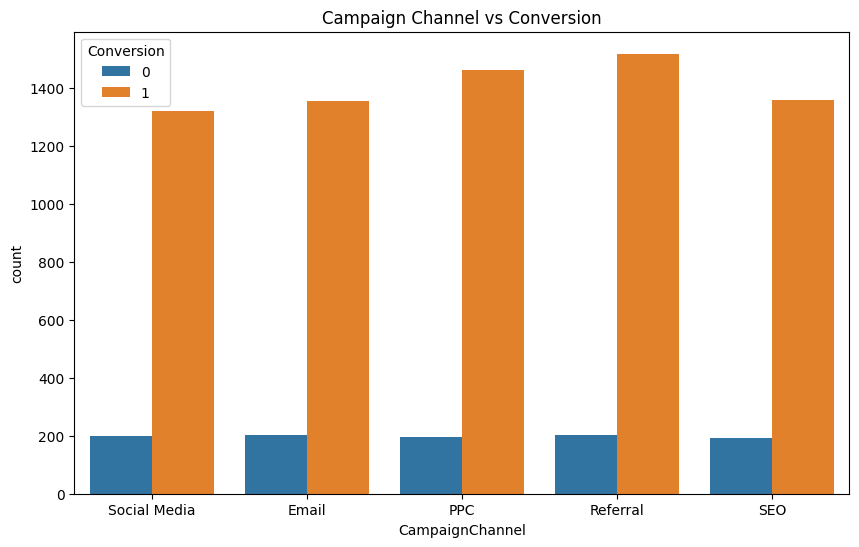

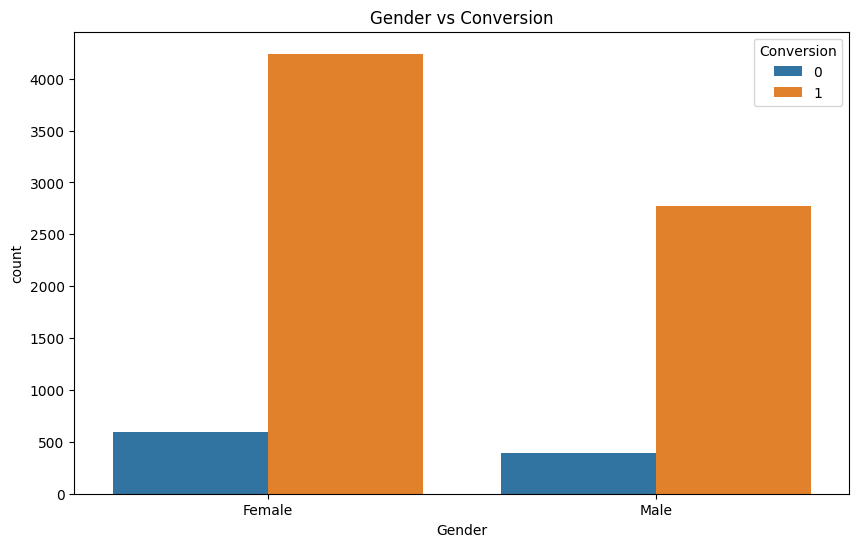

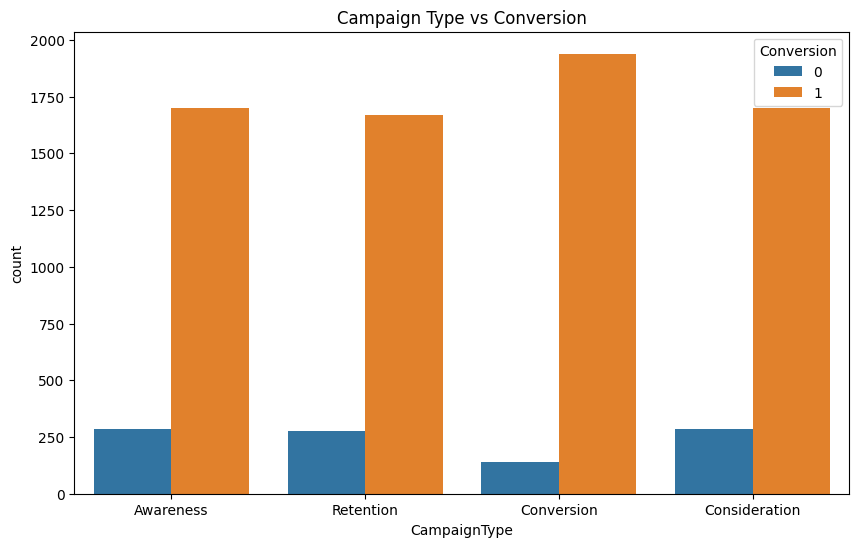

In [17]:
# Count plots for categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(x="CampaignChannel", hue="Conversion", data= marketing_data)
plt.legend(title="Conversion", loc="best")
plt.title("Campaign Channel vs Conversion")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x="Gender", hue="Conversion", data=marketing_data)
plt.legend(title="Conversion", loc="best")
plt.title("Gender vs Conversion")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x="CampaignType", hue="Conversion", data=marketing_data)
plt.legend(title="Conversion", loc="best")
plt.title("Campaign Type vs Conversion")
plt.show()

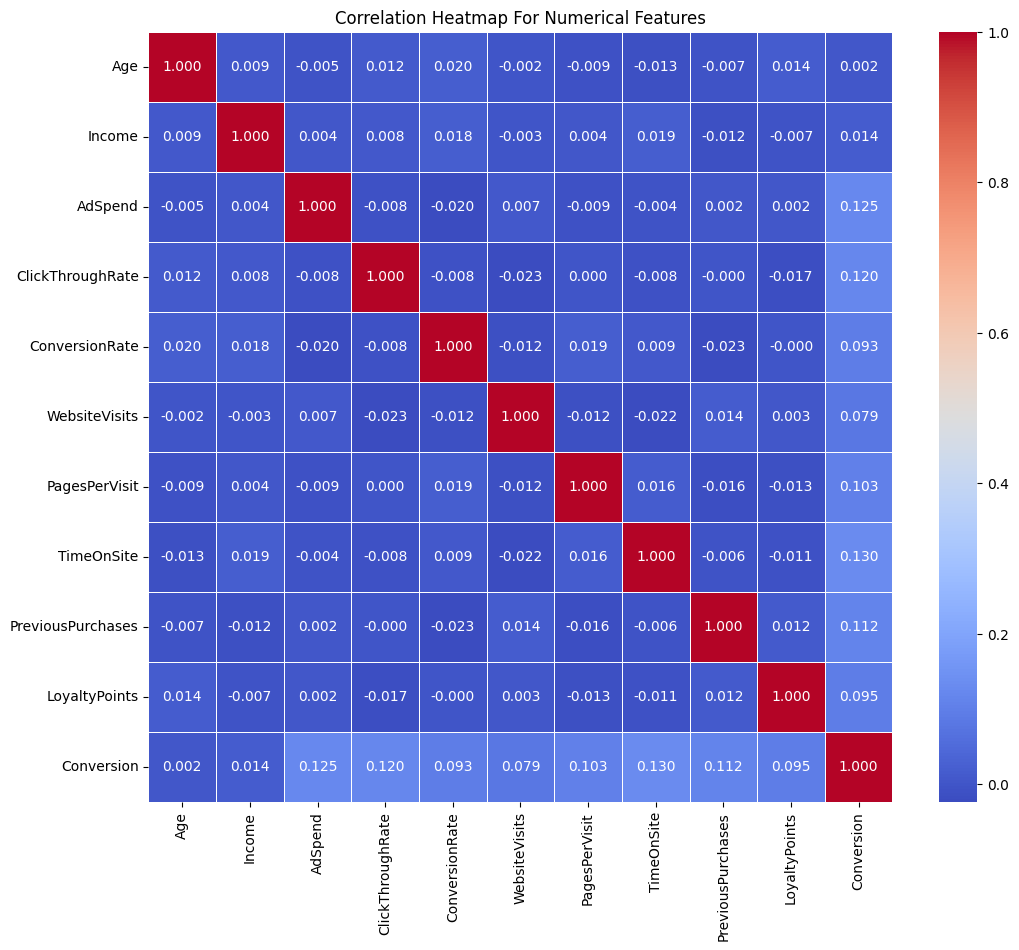

In [26]:
# Correlation matrix for numerical features
corr_matrix = marketing_data[['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'PreviousPurchases', 'LoyaltyPoints', 'Conversion']].corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation Heatmap For Numerical Features')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.3f')
plt.show()

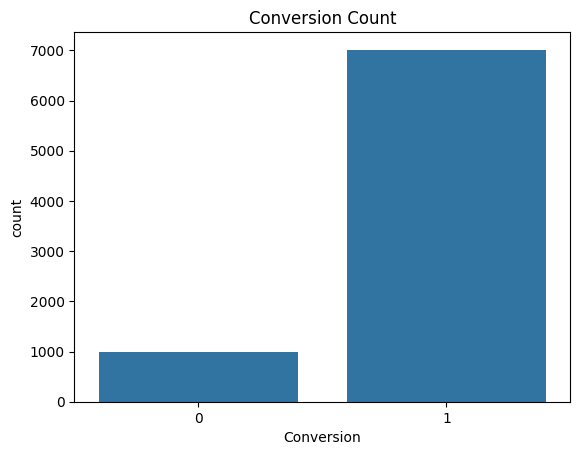

In [19]:
# Plot for the count of conversions
sns.countplot(x='Conversion', data= marketing_data)
plt.title('Conversion Count') 
plt.show() 

In [20]:
# Function to remove null, NaN and empty values from the dataset.
def remove_null_nan_empty(data):
    data = data.dropna()
    data = data.replace(r'^\s*$', np.nan, regex=True)
    data = data.dropna()
    return data

# Apply the function to the dataset
marketing_data = remove_null_nan_empty(marketing_data)

# Identify categorical columns for encoding
categorical_columns = ["Gender", "CampaignChannel", "CampaignType"]

# Create a ColumnTransformer for one-hot encoding
# This will transform categorical variables into binary columns
ct = ColumnTransformer(
    [("encoder", OneHotEncoder(drop="first"), categorical_columns)],
    remainder="passthrough",
)

# Fit the ColumnTransformer to the data and transform it
encoded_data = ct.fit_transform(marketing_data)

# Get the feature names after encoding
feature_names = ct.get_feature_names_out()

# Clean up the feature names by removing the prefix
feature_names_cleaned = [name.split("__")[-1] for name in feature_names]

# Create a new DataFrame with the encoded data using the cleaned feature names
encoded_df = pd.DataFrame(encoded_data, columns=feature_names_cleaned)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.14      0.25       194
         1.0       0.89      1.00      0.94      1406

    accuracy                           0.89      1600
   macro avg       0.88      0.57      0.60      1600
weighted avg       0.89      0.89      0.86      1600



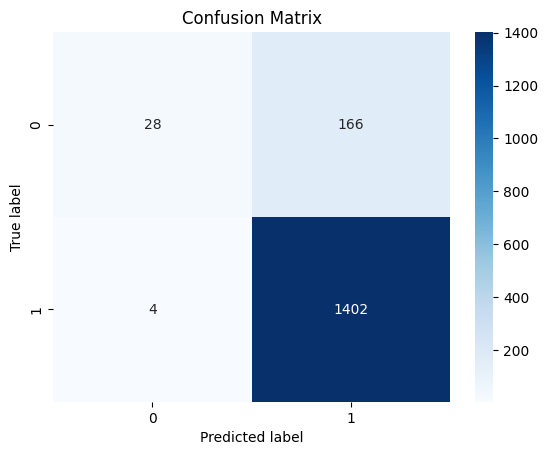

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

# Separate features and target variable
X = encoded_df.drop(["Conversion"], axis=1)
y = encoded_df["Conversion"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the random forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test)

# Show detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Generate a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

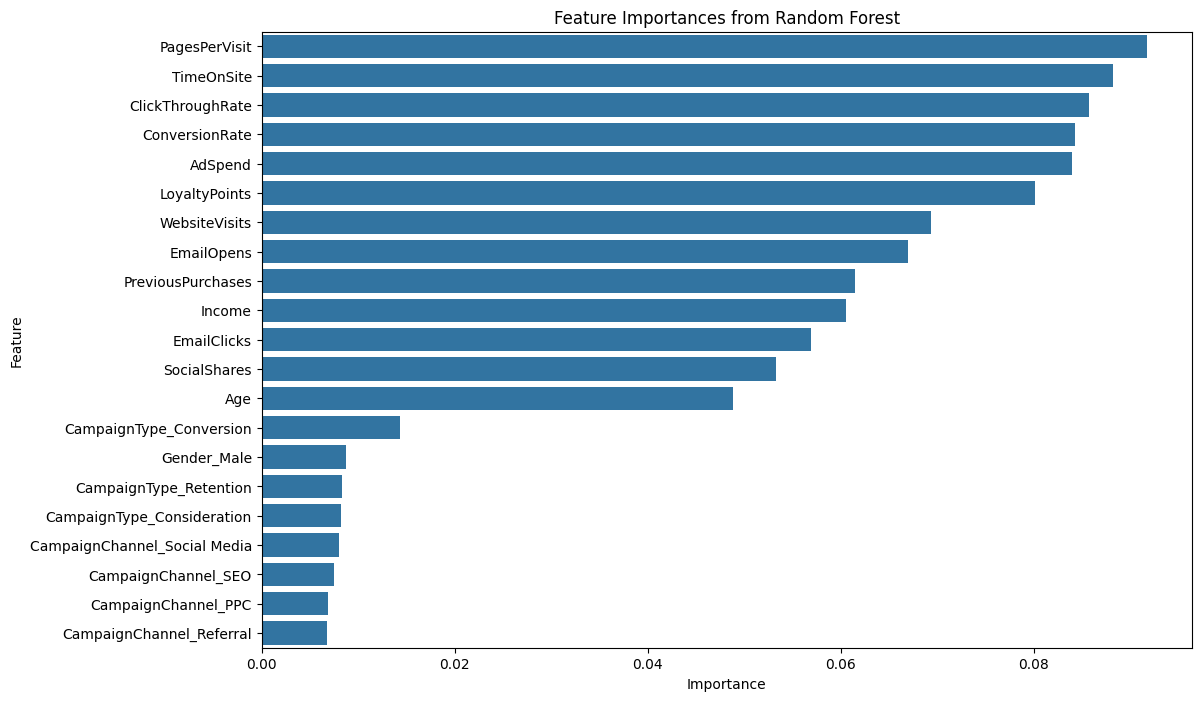

In [22]:
# Extract feature importances from the trained random forest model
importances = rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances and sort 
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Bar chart of feature importances
plt.figure(figsize=(12, 8))  
sns.barplot(x='Importance', y='Feature', data=feature_importances) 
plt.title('Feature Importances from Random Forest')  
plt.show()  



Results with Class Weight 'Balanced':

Classification Report (Balanced):

              precision    recall  f1-score   support

         0.0       0.90      0.09      0.17       194
         1.0       0.89      1.00      0.94      1406

    accuracy                           0.89      1600
   macro avg       0.89      0.55      0.55      1600
weighted avg       0.89      0.89      0.85      1600



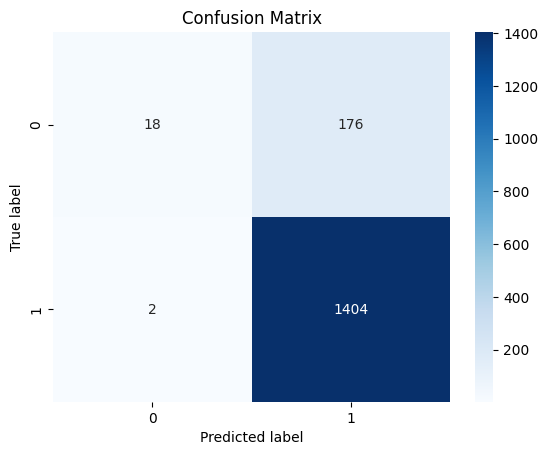

In [23]:
# Train the random forest classifier with class_weight='balanced' to account for imbalanced classes
rf_model_balanced = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model_balanced.fit(X_train, y_train)

# Predict the test set
y_pred_balanced = rf_model_balanced.predict(X_test)

# Display the results
print("\nResults with Class Weight 'Balanced':")

# Show detailed classification report
print("\nClassification Report (Balanced):\n")
print(classification_report(y_test, y_pred_balanced))

# Generate a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

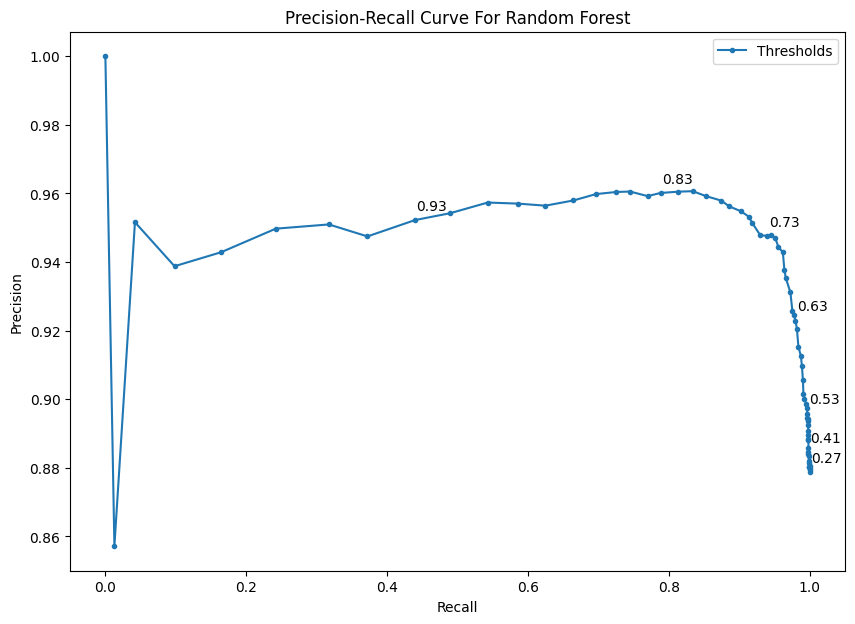


Results with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.67      0.58      0.62       194
         1.0       0.94      0.96      0.95      1406

    accuracy                           0.92      1600
   macro avg       0.81      0.77      0.79      1600
weighted avg       0.91      0.92      0.91      1600



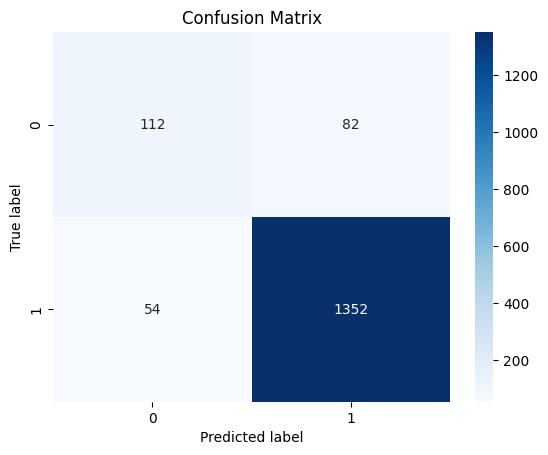

In [24]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)

plt.figure(figsize=(10, 7))

for i in range(0, len(thresholds), 10):  # Annotate every 10th threshold
    plt.annotate(
        f"{thresholds[i]:.2f}",
        (recalls[i], precisions[i]),
        textcoords="offset points",
        ha="center",
        va="top",
        xytext=(12, 15)
    )

# Plot the Precision-Recall curve
plt.plot(recalls, precisions, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve For Random Forest")
plt.legend(labels=['Thresholds'])
plt.show()

# Find the optimal threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Make predictions using the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)


# Display the results
print("\nResults with Optimal Threshold:")

# Evaluate the model
print(classification_report(y_test, y_pred_optimal))

# Generate a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [25]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Create 5 marketing campaigns without the website-related fields
campaigns = pd.DataFrame(
    {
        "CampaignName": [
            "Campaign 1",
            "Campaign 2",
            "Campaign 3",
            "Campaign 4",
            "Campaign 5",
        ],
        "CampaignChannel": ["PPC", "SEO", "Social Media", "Referral", "PPC"],
        "CampaignType": [
            "Conversion",
            "Consideration",
            "Retention",
            "Conversion",
            "Retention",
        ],
        "AdSpend": [7000, 5000, 3000, 9000, 4500],
        "ClickThroughRate": [0.28, 0.22, 0.08, 0.29, 0.16],
        "ConversionRate": [0.18, 0.15, 0.07, 0.18, 0.12],
    }
)

# Input widgets for customer data
age_input = widgets.IntText(
    description="Age:", value=30, layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"}
)
gender_input = widgets.Dropdown(
    options=["Male", "Female"],
    description="Gender:",
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)
income_input = widgets.FloatText(
    description="Income:", value=50000, layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"}
)

previous_purchases_input = widgets.IntText(
    description="Previous Purchases:",
    value=5,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

loyalty_points_input = widgets.IntText(
    description="Loyalty Points:",
    value=100,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

website_visits_input = widgets.IntText(
    description="Website Visits:",
    value=45,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

pages_per_visit_input = widgets.FloatText(
    description="Pages per Visit:",
    value=7.8,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

time_on_site_input = widgets.FloatText(
    description="Time on Site (min):",
    value=12.5,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

social_shares_input = widgets.IntText(
    description="Social Shares:",
    value=75,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

email_opens_input = widgets.IntText(
    description="Email Opens:",
    value=18,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

email_clicks_input = widgets.IntText(
    description="Email Clicks:",
    value=8,
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

# Dropdown for selecting the campaign
campaign_dropdown = widgets.Dropdown(
    options=[(row["CampaignName"], index) for index, row in campaigns.iterrows()],
    description="Select Campaign:",
    layout=widgets.Layout(width="300px"),
    style={"description_width": "150px"},
)

# Submit button
predict_button = widgets.Button(
    description="Predict", layout=widgets.Layout(width="200px")
)

# Display widgets
title = widgets.HTML(value="<h2>Customer Conversion Prediction Tool</h2>")
display(title)

# Display customer information inputs
display(
    age_input,
    gender_input,
    income_input,
    previous_purchases_input,
    loyalty_points_input,
    website_visits_input,
    pages_per_visit_input,
    time_on_site_input,
    social_shares_input,
    email_opens_input,
    email_clicks_input,
    campaign_dropdown,
    predict_button,
)

out = widgets.Output()

display(out)

# This section is responsible for handling the prediction button click event
def on_predict_button_clicked(b):
    # Retrieve selected campaign information
    selected_index = campaign_dropdown.value
    selected_campaign = campaigns.iloc[selected_index]

    # One-hot encode CampaignChannel and CampaignType
    campaign_channel = selected_campaign["CampaignChannel"]
    campaign_type = selected_campaign["CampaignType"]

    # Initialize one-hot encoding dictionaries
    campaign_channels = ["PPC", "SEO", "Social Media", "Referral"]
    campaign_types = ["Consideration", "Conversion", "Retention"]

    campaign_encoded = {}

    # One-hot encode campaign channels
    for channel in campaign_channels:
        key = "CampaignChannel_" + channel
        campaign_encoded[key] = 1 if campaign_channel == channel else 0

    # One-hot encode campaign types
    for type_ in campaign_types:
        key = "CampaignType_" + type_
        campaign_encoded[key] = 1 if campaign_type == type_ else 0

    # Create user data dictionary
    user_data = {
        "Age": age_input.value,
        "Gender_Male": 1 if gender_input.value == "Male" else 0,
        "Income": income_input.value,
        **campaign_encoded,
        "AdSpend": selected_campaign["AdSpend"],
        "ClickThroughRate": selected_campaign["ClickThroughRate"],
        "ConversionRate": selected_campaign["ConversionRate"],
        "WebsiteVisits": website_visits_input.value,
        "PagesPerVisit": pages_per_visit_input.value,
        "TimeOnSite": time_on_site_input.value,
        "SocialShares": social_shares_input.value,
        "EmailOpens": email_opens_input.value,
        "EmailClicks": email_clicks_input.value,
        "PreviousPurchases": previous_purchases_input.value,
        "LoyaltyPoints": loyalty_points_input.value,
    }

    # Convert user_data to DataFrame
    user_data_df = pd.DataFrame([user_data])

    # Ensure the columns match the training data
    user_data_df = user_data_df.reindex(columns=X.columns, fill_value=0)

    # Predict the probability of conversion for the user
    user_prob = rf_model.predict_proba(user_data_df)[:, 1]
    # Determine if the user is likely to convert based on the optimal threshold
    user_pred_optimal = (user_prob >= optimal_threshold).astype(int)

    with out:
        out.clear_output(wait=True)  # Clear any previous output
        if user_pred_optimal[0] == 1:
            print("The customer is likely to convert.")
        else:
            print("The customer is not likely to convert.")


predict_button.on_click(on_predict_button_clicked)


HTML(value='<h2>Customer Conversion Prediction Tool</h2>')

IntText(value=30, description='Age:', layout=Layout(width='300px'), style=DescriptionStyle(description_width='…

Dropdown(description='Gender:', layout=Layout(width='300px'), options=('Male', 'Female'), style=DescriptionSty…

FloatText(value=50000.0, description='Income:', layout=Layout(width='300px'), style=DescriptionStyle(descripti…

IntText(value=5, description='Previous Purchases:', layout=Layout(width='300px'), style=DescriptionStyle(descr…

IntText(value=100, description='Loyalty Points:', layout=Layout(width='300px'), style=DescriptionStyle(descrip…

IntText(value=45, description='Website Visits:', layout=Layout(width='300px'), style=DescriptionStyle(descript…

FloatText(value=7.8, description='Pages per Visit:', layout=Layout(width='300px'), style=DescriptionStyle(desc…

FloatText(value=12.5, description='Time on Site (min):', layout=Layout(width='300px'), style=DescriptionStyle(…

IntText(value=75, description='Social Shares:', layout=Layout(width='300px'), style=DescriptionStyle(descripti…

IntText(value=18, description='Email Opens:', layout=Layout(width='300px'), style=DescriptionStyle(description…

IntText(value=8, description='Email Clicks:', layout=Layout(width='300px'), style=DescriptionStyle(description…

Dropdown(description='Select Campaign:', layout=Layout(width='300px'), options=(('Campaign 1', 0), ('Campaign …

Button(description='Predict', layout=Layout(width='200px'), style=ButtonStyle())

Output()